# GD2. ResNet Ablation Study  
- Ablation Study : 직역하면 제거 연구
- 딥러닝 논문은 여러 가지 방법들을 결합해 어떤 문제를 해결하는 방법을 제시함. 
- 제안한 방법의 유효함을 증명하기 위해 딥러닝 논문에서는 해당 방법을 제거한 모델로 수행한 실험과, 해당 방법을 추가한 모델로 수행한 실험의 결과를 비교함. 
- 애블레이션 연구란 "아이디어를 제거함으로써" 제안한 방법이 어떻게 성능이나 문제 해결에 효과를 주는지 확인하는 실험임. 

### Ablation Study 실습 (1) CIFAR-10 데이터셋 준비하기  
- ResNet의 성능을 평가하기 위해 논문과 동일한 이미지넷의 훈련/검증 데이터셋을 사용해 학습과 평가를 진행하는 것이 이상적임.
- 하지만 컴퓨팅 자원이 부족하기에 이미지넷 대신에 적당한 크기의 CIFAR-10 데이터셋을 사용함. 
- CIFAR-10에 대해 일반 네트워크와 ResNet을 구현해서 이 둘을 비교해 ResNet 및 residual connection의 유효성을 확인.

#### 1) CIFAR-10
- CIFAR-10 데이터셋은 10개 카테고리에 대해 총 6만 장의 32x32 이미지가 있음.

In [1]:
!pip install tensorflow-datasets

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
# TensorFlow가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- CIFAR-10은 대용량 데이터셋은 아니지만 로드에 꽤 긴 시간이 걸림. 
- 데이터셋이 준비되면 클래스의 수와 클래스에 따른 이름을 볼 수 있음. (`DatasetBuilder`의 `info`로 확인)  
> `tfds.load()`는 기본적으로 `~/tensorflow_datasets`에 데이터셋을 다운로드함. 경로를 바꾸고 싶다면 `data_dir` 인자를 사용

In [4]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()  # 이 주석을 풀면 데이터셋 다운로드 과정의 진행 바가 나타나지 않음

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete47ESDQ/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete47ESDQ/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [5]:
# TensorFlow 데이터셋을 로드하면 꼭 feature 정보를 확인해보자. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [6]:
# 데이터 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


- TensorFlow의 데이터셋은 Numpy가 아니기에, `ds_train.shape` 같은 게 없음. 
- 위와 같은 방법으로 데이터셋의 이미지 shape과 전체 데이터의 개수, 라벨 클래스의 개수 등 중요한 정보를 확인할 수 있음. 

#### 2) Input Normalization
- Data Normalization은 데이터의 범위를 사용자가 원하는 범위로 제한하는 것. 
- 이미지의 경우 픽셀 정보를 0\~255 사이의 값으로 갖는데, 이를 255로 나누면 0~1.0 사이의 값을 갖게 됨.
- Data Normalization을 하는 이유는 머신러닝에서 scale이 큰 feature의 영향이 비대해지는 것을 방지, 딥러닝에서 Local optimum에 빠질 위험을 줄이기(학습 속도 향상) 위함임. 
- 한 픽셀이 가진 채널 값은 픽셀의 색을 표현함.
- 그레이 스캐일은 단순하게 흑과 백만을 표현하는 하나의 채널을 가진 이미지. 
- 모델에 넣기 전에 각 채널별 최댓값인 255로 **정규화(normalize)**를 해 이미지의 표현이 0과 1 사이로 들어오게 만듦.

In [7]:
def normalize_and_resize_img(image, label):
  """Normalizes images: 'uint8' -> 'float32'."""
  #image = tf.image.resize(image, [32, 32])
  return tf.cast(image, tf.float32) / 255., label

In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
  ds = ds.map(
      normalize_and_resize_img,
      num_parallel_calls=1
  )
  ds = ds.batch(batch_size)
  if not is_test:
    ds = ds.repeat()
    ds = ds.shuffle(200)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

In [9]:
ds_info.features['label'].num_classes

10

In [10]:
ds_info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

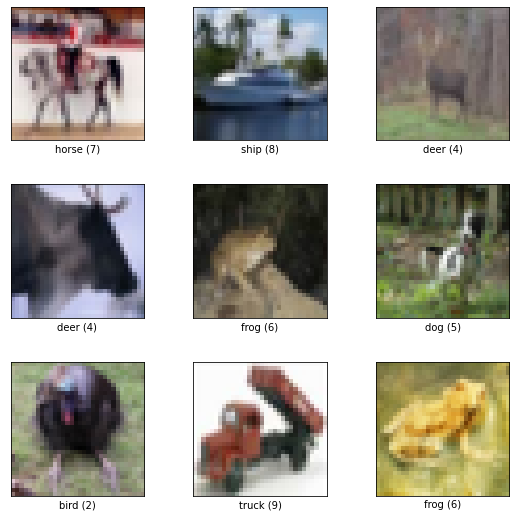

In [11]:
fig = tfds.show_examples(ds_train, ds_info)

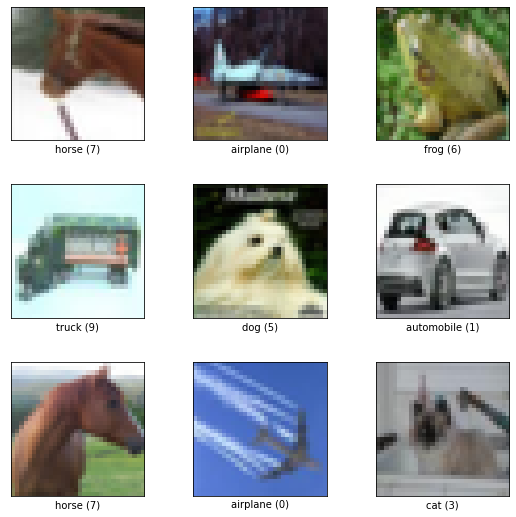

In [12]:
fig = tfds.show_examples(ds_test, ds_info)

### Ablation Study 실습 (2) 블록 구성하기
- 모델을 구현하는 과정에서 논문의 모델을 그대로 구현하는 것도 중요하지만, 구현 시 반복되는 부분을 줄여 하이퍼파라미터 혹은 변수를 변경하거나 모델 구조가 변경될 때 손쉽게 바꿀 수 있도록 만들어 놓는 것이 필요함. 
- 최근 나오는 일반적인 딥러닝 모델에서 주요 구조를 모듈화해 조금씩 바꾸어 쓸 수 있는 단위를 **블록(block)**이라 부름.
- **레이어(layer)**는 기본적으로 텐서플로우, 케라스, 파이토치 등에서 기본적으로 제공하는 단위임.
- 여기서 한 단계 위인 블록을 단위로 모델을 만들 수 있어야 함.  


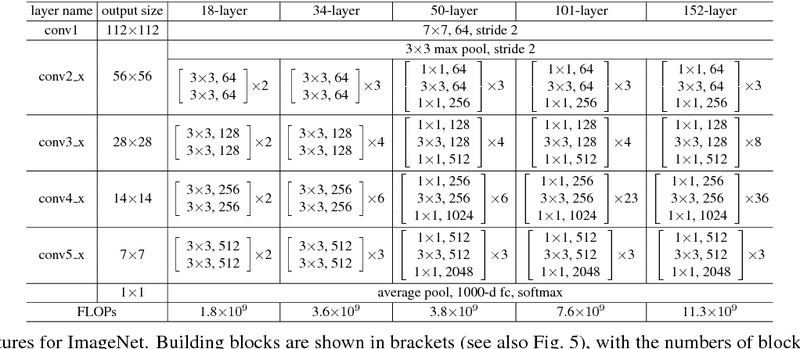

- ResNet을 보면 18, 34, 50, 101, 152로 다섯 가지 네트워크가 있음. 
- 각 네트워크를 하나씩 구현하는 방법도 있지만 불편하기 때문에 ResNet의 기본 구조인 블록을 먼저 구현해보자.  
> ResNet을 바로 구현하는 것은 어려울 수 있기에, 조금 더 간단한 블록이 반복되는 VGG를 예시로 구현해보자.  

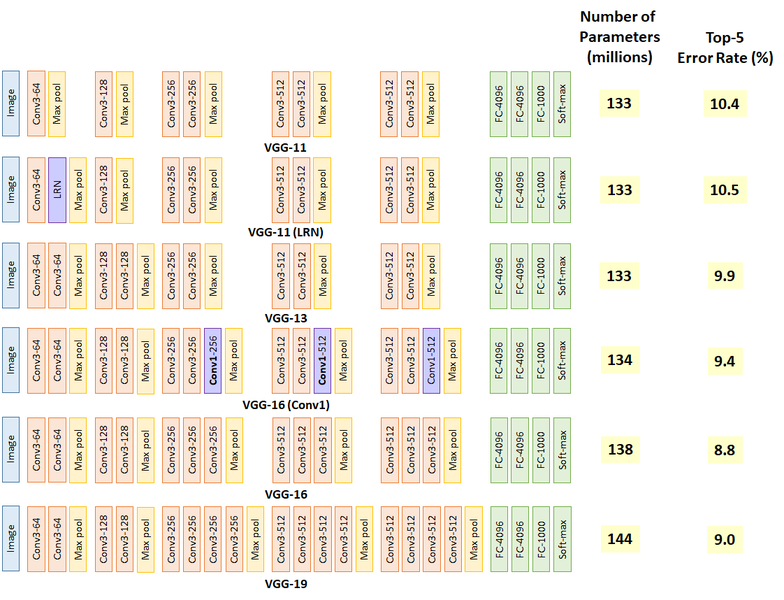

- VGG도 여러 가지 버전이 있는데, VGG-16과 VGG-19의 기본 구조가 되는 블록을 만든다고 가정하고 구현해보자. 
- VGG의 블록은 개략적으로 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어진다. 
- CNN은 모두 커널 크기가 3x3라는 대표적인 특징을 갖고 있다. 
- 블록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있다. 
- 블록에 따라서 CNN 레이어의 개수 또한 달라진다.
- 블록의 마지막에는 항상 Max Pooling 레이어가 붙는다. 
- 따라서 우리의 블록은 CNN 레이어 여러 개와 Max Pooling 레이어 한 개로 이루어질 것이고, CNN의 레이어와 채널 수를 조절할 수 있어야 함. 
- `block_num`은 레이어의 이름을 붙여주기 위해 추가되었고, `input_shape`은 summary를 출력하기 위함임. 

In [13]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3,
                    channel=64,
                    block_num=1,
                    ):
  # 입력 레이어
  x = input_layer

  # CNN 레이어
  for cnn_num in range(num_cnn):
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name=f'block{block_num}_conv{cnn_num}'
    )(x)

  # Max Pooling 레이어
  x = keras.layers.MaxPooling2D(
      pool_size=(2,2),
      strides=2,
      name=f'block{block_num}_pooling'
  )(x)

  return x

- VGG 블록을 추가하는 함수를 이용해 `input_layer`에 추가해보자. 
- 입력 레이어는 아까 데이터셋에서 확인한 32, 32의 크기를 갖고 채널로 3을 가지므로 (32, 32, 3)이 됨. 
- 이 입력 레이어를 인자로 받아 `building_vgg_block()`는 블록의 레이어를 build하고 출력값을 얻을 수 있음. 
- 케라스의 `Model` 클래스에서 `input`과 `output`을 정의해주면 간단히 모델을 확인해 볼 수 있음. 

In [14]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))  # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)  # VGG 블록 생성

In [15]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________

### Ablation Study 실습 (3) VGG Complete Model
- 기본적인 블록을 만들 수 있는 함수를 만들었으니 이를 합쳐서 전체 모델을 만들 수 있는 함수를 만들어본다. 

#### 1) VGG-16
- 블록 내의 CNN 레이어 수와 채널 수는 블록마다 달라진다. 
- 이는 VGG-16, VGG-19에 따라서 같이 변환되므로 함수에 전달되어야 함. 
- 여기서는 각 블록 별 CNN의 수와 채널을 리스트로 전달. 

In [16]:
# VGG 모델 자체를 생성하는 함수
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
  assert len(num_cnn_list) == len(channel_list)  # 모델을 만들기 전에 config list들이 같은 길이인지 확인

  input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어 둔다.
  output = input_layer
  
  # config list들의 길이만큼 반복해서 블록을 생성
  for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
    output = build_vgg_block(
        output,
        num_cnn=num_cnn,
        channel=channel,
        block_num=i
    )

  output = keras.layers.Flatten(name='flatten')(output)
  output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
  output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
  output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)

  model = keras.Model(
      inputs=input_layer,
      outputs=output
  )

  return model

In [17]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 된다. 
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

#### 2) VGG-19
- 위에서 16을 만들었으니 쉽게 구성(configuration)을 바꿔서 VGG-19를 만들 수 있다. 

In [18]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해준다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

### Ablation Study 실습 (4) VGG-16 vs VGG-19
- 이제 본격적으로 위에서 준비한 데이터셋과 모델의 성능 비교를 위해 모델을 훈련하고 평가해보자. 
- VGG는 레이어의 차이를 위해 VGG-16과 VGG-19를 비교해보자. 
- 우선 CIFAR-10 데이터셋을 불러온다.

In [19]:
BATCH_SIZE = 256
EPOCH = 15

In [20]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

- VGG-16 모델을 만들고 훈련시켜보자. 
- 이 훈련은 40 Epoch 정도 수행할 것을 권장하지만, 15 Epoch 정도로도 어느 정도 근접하는 성능을 얻을 수는 있을 것이다. 

In [21]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 39s 95ms/step - loss: 2.1756 - accuracy: 0.1901 - val_loss: 2.0524 - val_accuracy: 0.2529
Epoch 2/15
195/195 [==============================] - 17s 86ms/step - loss: 2.0003 - accuracy: 0.2771 - val_loss: 1.9226 - val_accuracy: 0.3038
Epoch 3/15
195/195 [==============================] - 17s 87ms/step - loss: 1.8710 - accuracy: 0.3283 - val_loss: 1.8036 - val_accuracy: 0.3725
Epoch 4/15
195/195 [==============================] - 17s 85ms/step - loss: 1.7526 - accuracy: 0.3736 - val_loss: 1.7116 - val_accuracy: 0.3919
Epoch 5/15
195/195 [==============================] - 17s 85ms/step - loss: 1.6804 - accuracy: 0.3967 - val_loss: 1.7231 - val_accuracy: 0.3676
Epoch 6/15
195/195 [==============================] - 17s 85ms/step - loss: 1.6131 - accuracy: 0.4194 - val_loss: 1.6060 - val_accuracy: 0.4227
Epoch 7/15
195/195 [==============================] - 16s 85ms/step - loss: 1.5607 - accuracy: 0.4396 - val_loss: 1.5459 - val_accuracy: 0.4465
Epo

- VGG-19 모델을 만들고 훈련시켜보자. 
- 파라미터가 더 많은 VGG-19는 VGG-16보다 1/4 정도 훈련 시간이 더 걸린다. Epoch와 BATCH_SIZE를 잘 조절해보자. 

In [22]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 24s 98ms/step - loss: 2.2580 - accuracy: 0.1532 - val_loss: 2.1953 - val_accuracy: 0.1877
Epoch 2/15
195/195 [==============================] - 19s 96ms/step - loss: 2.1049 - accuracy: 0.2246 - val_loss: 2.0280 - val_accuracy: 0.2550
Epoch 3/15
195/195 [==============================] - 19s 98ms/step - loss: 1.9716 - accuracy: 0.2835 - val_loss: 1.8831 - val_accuracy: 0.3300
Epoch 4/15
195/195 [==============================] - 19s 97ms/step - loss: 1.8398 - accuracy: 0.3311 - val_loss: 1.7733 - val_accuracy: 0.3541
Epoch 5/15
195/195 [==============================] - 19s 97ms/step - loss: 1.7400 - accuracy: 0.3701 - val_loss: 1.7264 - val_accuracy: 0.3729
Epoch 6/15
195/195 [==============================] - 19s 97ms/step - loss: 1.6653 - accuracy: 0.3969 - val_loss: 1.6425 - val_accuracy: 0.4048
Epoch 7/15
195/195 [==============================] - 19s 96ms/step - loss: 1.6076 - accuracy: 0.4198 - val_loss: 1.5915 - val_accuracy: 0.4259
Epo

- VGG-16과 VGG-19를 그래프를 그리고 비교해보도록 하자. 
- 먼저 훈련 손실(training loss)이 어떻게 다르게 진행되는지 비교해보자. 

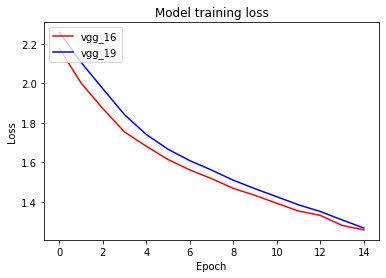

In [23]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

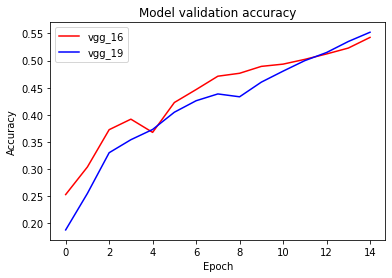

In [24]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()